In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator , TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv("train.csv")

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<Axes: >

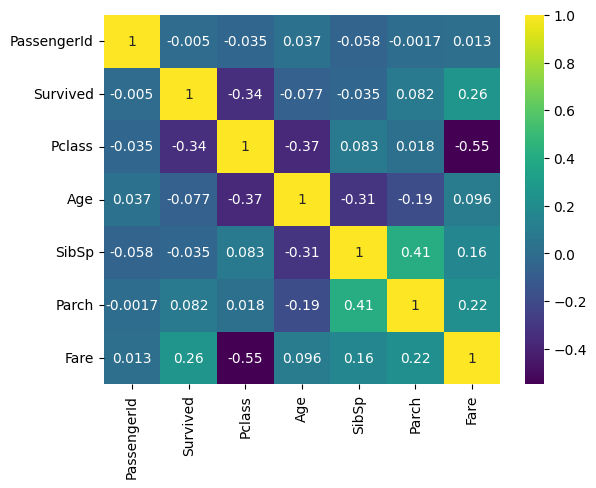

In [5]:
sns.heatmap(df.corr(numeric_only = True), annot = True , cmap = "viridis")

In [6]:
split = StratifiedShuffleSplit(n_splits = 1  , test_size = 0.2)
for train_indices , test_indices in split.split(df , df[["Survived", "Pclass", "Sex"]]):
    strat_train_set = df.loc[train_indices]
    strat_test_set = df.loc[test_indices]

In [30]:
class AgeImputer(BaseEstimator , TransformerMixin):
    def fit(self , x , y = None):
        return self
    def transform(self , x):
        imputer = SimpleImputer(strategy = "mean")
        x['Age'] = imputer.fit_transform(x[['Age']])
        return x
        


In [45]:
class FeatureEncoder(BaseEstimator , TransformerMixin):
    def fit(self, x, y = None):
        return self
    def transform(self , x):
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(x[['Embarked']]).toarray()
        column_names = ['C','S','Q','N']
        for i in range(len(matrix.T)):
            x[column_names[i]] = matrix.T[i]
        matrix = encoder.fit_transform(x[['Sex']]).toarray()
        column_names = ['M','F']
        for i in range(len(matrix.T)):
            x[column_names[i]] = matrix.T[i]
        return x
        

In [57]:
class FeatureDropper(BaseEstimator , TransformerMixin):
    def fit(self , x, y = None):
        return self
    def transform(self , x):
        return x.drop(["Embarked", "Sex", "Cabin", "Ticket","Name", "N"] , axis = 1 , errors = "ignore")

In [86]:
pipeline = Pipeline([("AgeImputer" , AgeImputer()) , 
                    ("FeatureEncoder" , FeatureEncoder()),
                    ("FeatureDropper" , FeatureDropper())])

In [87]:
train_set = pipeline.fit_transform(strat_test_set)

In [60]:
train_set

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,M,F
877,878,0,3,19.00000,0,0,7.8958,0.0,0.0,1.0,0.0,1.0
475,476,0,1,29.46255,0,0,52.0000,0.0,0.0,1.0,0.0,1.0
252,253,0,1,62.00000,0,0,26.5500,0.0,0.0,1.0,0.0,1.0
569,570,1,3,32.00000,0,0,7.8542,0.0,0.0,1.0,0.0,1.0
191,192,0,2,19.00000,0,0,13.0000,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
253,254,0,3,30.00000,1,0,16.1000,0.0,0.0,1.0,0.0,1.0
210,211,0,3,24.00000,0,0,7.0500,0.0,0.0,1.0,0.0,1.0
563,564,0,3,29.46255,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
527,528,0,1,29.46255,0,0,221.7792,0.0,0.0,1.0,0.0,1.0


In [56]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179 entries, 877 to 487
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  179 non-null    int64  
 1   Survived     179 non-null    int64  
 2   Pclass       179 non-null    int64  
 3   Age          179 non-null    float64
 4   SibSp        179 non-null    int64  
 5   Parch        179 non-null    int64  
 6   Ticket       179 non-null    object 
 7   Fare         179 non-null    float64
 8   Cabin        46 non-null     object 
 9   C            179 non-null    float64
 10  S            179 non-null    float64
 11  Q            179 non-null    float64
 12  M            179 non-null    float64
 13  F            179 non-null    float64
dtypes: float64(7), int64(5), object(2)
memory usage: 21.0+ KB


In [67]:
X = train_set.drop("Survived" , axis= 1)
Y = train_set["Survived"]
scaler = StandardScaler()
x_data = scaler.fit_transform(X)
y_data = Y.to_numpy()

In [132]:
rfc = RandomForestClassifier()
param_grid = [
    {"n_estimators": [ 100, 200 ,500 , 1000] , "max_depth":  [None , 5 , 10 ] , "min_samples_split": [2,3,4]}
]
grid_search = GridSearchCV(rfc , param_grid , cv = 3 , scoring = "accuracy" , return_train_score = True)
grid_search.fit(X , Y)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [100, 200, 500, 1000]}],
             return_train_score=True, scoring='accuracy')

In [133]:
final = grid_search.best_estimator_
final

RandomForestClassifier()

In [134]:
test_set = pipeline.fit_transform(strat_test_set)

In [135]:
test_set

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,M,F
877,878,0,3,19.00000,0,0,7.8958,0.0,0.0,1.0,0.0,1.0
475,476,0,1,29.46255,0,0,52.0000,0.0,0.0,1.0,0.0,1.0
252,253,0,1,62.00000,0,0,26.5500,0.0,0.0,1.0,0.0,1.0
569,570,1,3,32.00000,0,0,7.8542,0.0,0.0,1.0,0.0,1.0
191,192,0,2,19.00000,0,0,13.0000,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
253,254,0,3,30.00000,1,0,16.1000,0.0,0.0,1.0,0.0,1.0
210,211,0,3,24.00000,0,0,7.0500,0.0,0.0,1.0,0.0,1.0
563,564,0,3,29.46255,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
527,528,0,1,29.46255,0,0,221.7792,0.0,0.0,1.0,0.0,1.0


In [136]:
X_test = test_set.drop("Survived", axis = 1)
Y_test = test_set['Survived']
scaler = StandardScaler()
X_data_test = scaler.fit_transform(X_test)
Y_data_test = Y_test.to_numpy()

In [137]:
final.score(X_data_test , Y_data_test)

C:\Users\sneha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.7988826815642458

In [138]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [139]:
final_data = pipeline.fit_transform(df)

In [140]:
final_data

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,M,F
0,1,0,3,22.000000,1,0,7.2500,0.0,0.0,1.0,0.0,1.0
1,2,1,1,38.000000,1,0,71.2833,1.0,0.0,0.0,1.0,0.0
2,3,1,3,26.000000,0,0,7.9250,0.0,0.0,1.0,1.0,0.0
3,4,1,1,35.000000,1,0,53.1000,0.0,0.0,1.0,1.0,0.0
4,5,0,3,35.000000,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.000000,0,0,13.0000,0.0,0.0,1.0,0.0,1.0
887,888,1,1,19.000000,0,0,30.0000,0.0,0.0,1.0,1.0,0.0
888,889,0,3,29.699118,1,2,23.4500,0.0,0.0,1.0,1.0,0.0
889,890,1,1,26.000000,0,0,30.0000,1.0,0.0,0.0,0.0,1.0


In [141]:
X_test_df = test_set.drop("Survived", axis = 1)
Y_test_df = test_set['Survived']
scaler = StandardScaler()
X_data_test_df = scaler.fit_transform(X_test_df)
Y_data_test_df = Y_test.to_numpy()

In [143]:
revised_rfc = RandomForestClassifier()
param_grid = [
    {"n_estimators": [ 100, 200 ,500 , 1000] , "max_depth":  [None , 5 , 10 ] , "min_samples_split": [2,3,4]}
]
grid_search = GridSearchCV(revised_rfc , param_grid , cv = 3 , scoring = "accuracy" , return_train_score = True)
grid_search.fit(X_data_test_df , Y_data_test_df)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [100, 200, 500, 1000]}],
             return_train_score=True, scoring='accuracy')

In [145]:
final_estimator = grid_search.best_estimator_
final_estimator

RandomForestClassifier(max_depth=5, min_samples_split=3)

In [146]:
titanic_test_data = pd.read_csv("test.csv")

In [147]:
titanic_test_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [148]:
final_test_data = pipeline.fit_transform(titanic_test_data)

In [149]:
final_test_data

,PassengerId,Pclass,Age,SibSp,Parch,Fare,C,S,Q,M,F
0,892,3,34.50000,0,0,7.8292,0.0,1.0,0.0,0.0,1.0
1,893,3,47.00000,1,0,7.0000,0.0,0.0,1.0,1.0,0.0
2,894,2,62.00000,0,0,9.6875,0.0,1.0,0.0,0.0,1.0
3,895,3,27.00000,0,0,8.6625,0.0,0.0,1.0,0.0,1.0
4,896,3,22.00000,1,1,12.2875,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,30.27259,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
414,1306,1,39.00000,0,0,108.9000,1.0,0.0,0.0,1.0,0.0
415,1307,3,38.50000,0,0,7.2500,0.0,0.0,1.0,0.0,1.0
416,1308,3,30.27259,0,0,8.0500,0.0,0.0,1.0,0.0,1.0


In [151]:
final_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Age          418 non-null    float64
 3   SibSp        418 non-null    int64  
 4   Parch        418 non-null    int64  
 5   Fare         417 non-null    float64
 6   C            418 non-null    float64
 7   S            418 non-null    float64
 8   Q            418 non-null    float64
 9   M            418 non-null    float64
 10  F            418 non-null    float64
dtypes: float64(7), int64(4)
memory usage: 36.1 KB


In [155]:
x_final_test = final_test_data
x_final_test = x_final_test.ffill()
scaler = StandardScaler()
x_final_test_dataset = scaler.fit_transform(x_final_test)
x_final_test_dataset

array([[-1.72791209,  0.87348191,  0.3349926 , ..., -1.35067551,
        -0.75592895,  0.75592895],
       [-1.71962474,  0.87348191,  1.32553003, ...,  0.74037028,
         1.32287566, -1.32287566],
       [-1.71133739, -0.31581919,  2.51417495, ..., -1.35067551,
        -0.75592895,  0.75592895],
       ...,
       [ 1.71133739,  0.87348191,  0.65196458, ...,  0.74037028,
        -0.75592895,  0.75592895],
       [ 1.71962474,  0.87348191,  0.        , ...,  0.74037028,
        -0.75592895,  0.75592895],
       [ 1.72791209,  0.87348191,  0.        , ..., -1.35067551,
        -0.75592895,  0.75592895]], shape=(418, 11))

In [157]:
predictions = final_estimator.predict(x_final_test_dataset)

In [158]:
predictions

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [163]:
final_df = pd.DataFrame(titanic_test_data['PassengerId'])
final_df['Survived'] = predictions
final_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [165]:
final_df.to_csv("predictions.csv", index = False)